In [140]:
from processing_functions import *
%matplotlib inline

In [141]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [143]:
# Drop build feature
personal_data = personal_data.drop(['build'], axis=1)
# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_'], ['ovar_cancer'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of inad_ cols: 42
['inad

In [144]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


In [149]:

# Prints the table of missing values with columns for df filtered for each of the values of on_col
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=True):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    # since get_cols_missing_percentage will produce columns with the same names, we want to create suffixes to differentiate over on_col values
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    # We are going to merge all of the 
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}', show_missing=show_missing)
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0, join='outer', suffixes=['_cancer', '_no_cancer']):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    merged_df = None
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:
            df_on_col = df[df[on_col] == on_col_val]
            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=False)
        df = impute_with_val(df, df.columns, -1)
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)

## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

In [159]:
# Mean impute before converting into features
screen_data = mean_impute(screen_data, select_numeric_columns(screen_data))
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', ['study_yr'])
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')
# Mean impute after converting into features
merged_data_screen = mean_impute(merged_data_screen, select_numeric_columns(merged_data_screen))

# Drop features that are 100% missing
merged_data_screen = drop_cols_missing_percentage(100, merged_data_screen, 'merged_data_screen')

Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849
Removing features that are over 100% missing
6 columns were over 100 missing. This is the list of columns: ['tvures_qvis3__study_yr_0', 'tvures_qvis3__study_yr_1', 'tvures_qvis3__study_yr_2', 'tvures_qvis3__study_yr_4', 'tvures_qvis3__study_yr_3', 'tvures_qvis3__study_yr_5']
The table of features missing over 100 percentage: 
+--------------------------+--------------------------+---------------+---------------+-------------------+
|                          | column_name              |   num_missing |   num_present |   percent_missing |
|--------------------------+--------------------------+---------------+---------------+-------------------|
| tvures_qvis3__study_yr_0 | tvures_qvis3__study_yr_0 |         30849 |             0 |               100 |
| tvures_qvis3__study_yr_1 | tvures_qvis3__study_yr_1 |         30849 |             0 |               100 |
| tvures_qvis3__study

In [162]:
# Mean Impute before converting into new features
screen_abnorm_data = mean_impute(screen_abnorm_data, select_numeric_columns(screen_abnorm_data))
# Turn screen dataset each year into a feature
make_unique_over_cols = ['study_yr', 'side', 'source', 'VISIT', 'sbcd']
merged_data_screen_abd = merge_df_into_features(screen_abnorm_data, 'plco_id', make_unique_over_cols)
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')
# Mean Impute before converting into new features
merged_data_screen_abd = mean_impute(merged_data_screen_abd, select_numeric_columns(merged_data_screen_abd))

# Drop features that are 100% missing
merged_data_screen_abd = drop_cols_missing_percentage(100, merged_data_screen_abd, 'merged_data_screen_abd')

# Convert Categorical features
merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})

Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992
Removing features that are over 100% missing
840 columns were over 100 missing. This is the list of columns: ['cyst__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'cyst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'echo__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'maxdi__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'volum__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'build_cancers__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cyst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'study_yr__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'sepst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'sepst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'solid__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'source__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'study_yr__study_yr_1_side_1_source_1_VISIT_3

In [163]:
# Drop profy features
proxy_features = [
    # 'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'fstcan_exitdays'
    ]
personal_data_cancer = personal_data_cancer.drop(proxy_features, axis=1)
personal_data_no_cancer = personal_data_no_cancer.drop(proxy_features, axis=1)

## Merging Datasets

In [179]:
# Merge cancer patients dataset with screen dataset and see missing values
merge_type_cancer = 'left'
merge_type_no_cancer = 'left'
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_cancer)
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how=merge_type_cancer)
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how=merge_type_no_cancer)
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how=merge_type_no_cancer)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together.

In [180]:

# Labeled Mean Impute before converting into new features
# merged_data_cancer = mean_impute(merged_data_cancer, select_numeric_columns(merged_data_cancer))
# merged_data_no_cancer = mean_impute(merged_data_no_cancer, select_numeric_columns(merged_data_no_cancer))

In [181]:
import time
x = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)
# Mean Impute before converting into new features
x = mean_impute(x, select_numeric_columns(x))
y = x['ovar_cancer']
x = x.drop(['ovar_cancer', 'plco_id'], axis=1)
oversampling = SMOTE()
x, y = oversampling.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")

In [169]:
# drop non-informative features
# x = x.drop(['ph_ovar_muq','orem_fyro'], axis=1)

In [170]:
# x = x.reset_index()
# y = y.reset_index()

## `TODO:` run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

LogisticRegression


c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   precision    recall  f1-score  support
0   0.949960  0.933126  0.941468  15462.0
1   0.934768  0.951210  0.942917  15577.0
ROC AUC score: 0.9673650461590921
Accuracy Score: 0.9422017461902767


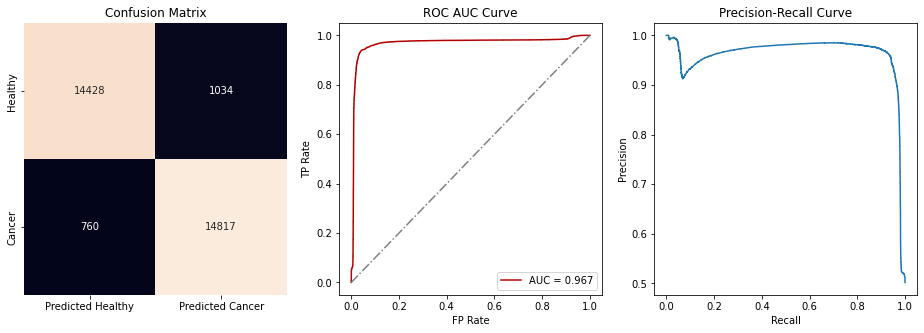

DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.999806  1.000000  0.999903  15462.0
1   1.000000  0.999807  0.999904  15577.0
ROC AUC score: 0.9999037041792387
Accuracy Score: 0.999903347401656


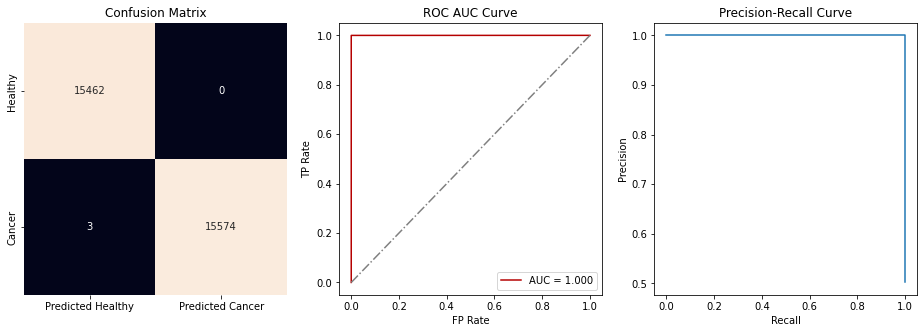

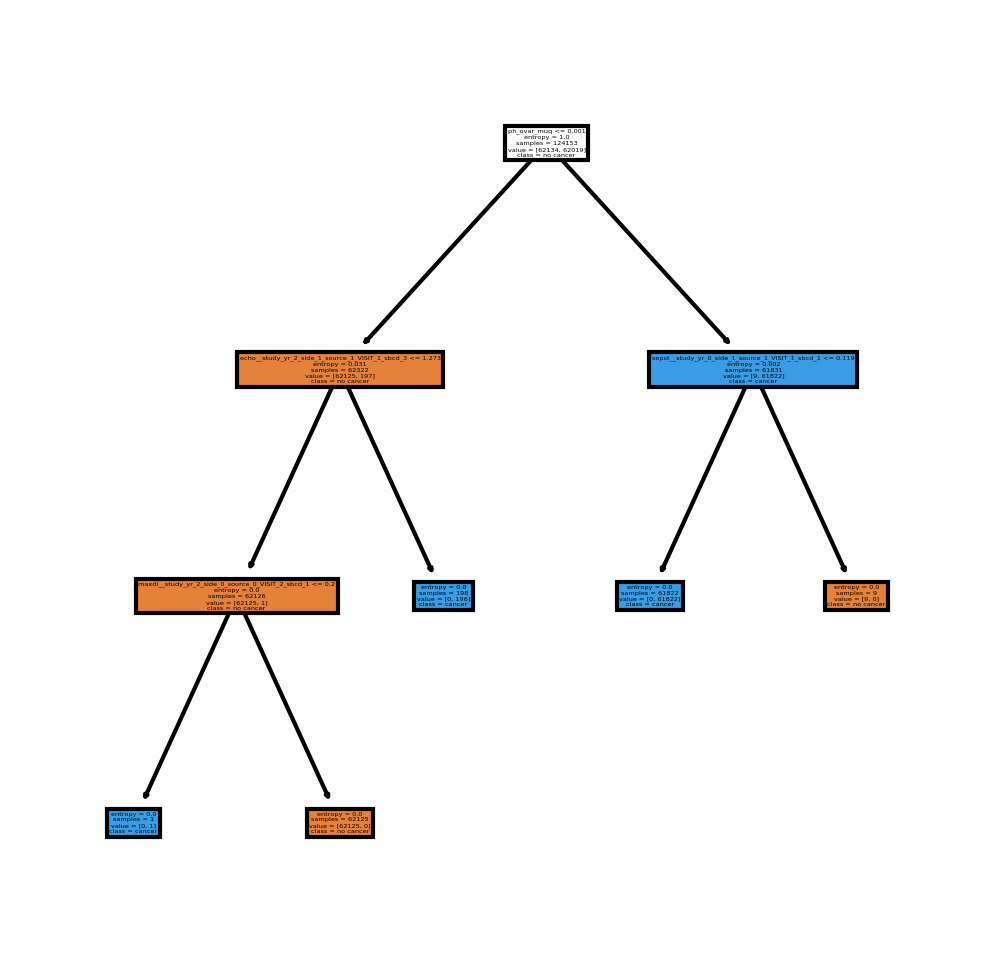

In [182]:
from sklearn.linear_model import LogisticRegression, LinearRegression
classifiers = {
    'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
from sklearn import tree

auc_dict = {}
accuracy_dict = {}
for classifier_type, classifier in classifiers.items():
    print(classifier_type)
    auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)
    if classifier_type == 'DecisionTreeClassifier':
        fn=X_train.columns
        cn=['no cancer', 'cancer']
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
        tree.plot_tree(classifier,
            feature_names = fn, 
            class_names=cn,
            filled = True)
        plt.show()
    auc_dict[classifier_type] = auc
    accuracy_dict[classifier_type] = accuracy

In [171]:
f_score(X_train, X_test, y_train, y_test, classifiers)

Score: 0.998 	 Time(in secs): 32.582 	 Classifier: DecisionTreeClassifier
Score: 0.998 	 Time(in secs): 57.185 	 Classifier: RandomForestClassifier
Score: 0.473 	 Time(in secs): 4.766 	 Classifier: GaussianNB
Score: 0.999 	 Time(in secs): 90.373 	 Classifier: XGBClassifier
Score: 0.816 	 Time(in secs): 33.65 	 Classifier: LogisticRegression


c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [172]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155192 entries, 0 to 155191
Columns: 1827 entries, build_cancers to build_incidence_cutoff__study_yr_0_side_0_source_1_VISIT_1_sbcd_2
dtypes: float64(1794), int64(33)
memory usage: 2.1 GB


In [173]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif

In [174]:


sel = SelectFromModel(XGBClassifier())
sel.fit(x,y)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

In [175]:
features = x.columns[(sel.get_support())]
print(len(features))
features

101


Index(['tvu_result0', 'tvu_result2', 'ca125_result0', 'ca125_result5',
       'ca125_level3', 'ca125_src1', 'orem_fyro', 'ca125_prot', 'educat',
       'pipe',
       ...
       'rlong_p__study_yr_3', 'rtran_p__study_yr_3', 'tvu_ref__study_yr_3',
       'physid__study_yr_3', 'tvu_result__study_yr_3', 'ovary_vol__study_yr_3',
       'tvu_days__study_yr_3',
       'maxdi__study_yr_3_side_0_source_0_VISIT_1_sbcd_1',
       'cyst__study_yr_2_side_0_source_0_VISIT_1_sbcd_1',
       'maxdi__study_yr_2_side_0_source_0_VISIT_1_sbcd_1'],
      dtype='object', length=101)

In [176]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# what are scores for the features
features_scores = pd.DataFrame(x.columns)
features_scores['scores'] = fs.scores_
features_scores = features_scores.sort_values('scores', ascending=False)
features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [   0    1   26   27   28   29  152  180  189  266  274  300  315  316
  317  318  319  320  327  328  329  330  331  332  333  343  351  377
  392  393  394  395  396  397  404  405  406  407  408  409  410  420
  497  574  582  651  652  653  654  655  663  664  665  666  667  668
  669  677  678  679  680  681  682  683  691  692  693  694  695  696
  697  705  706  707  708  709  710  711  719  720  721  722  723  724
  725  726  727  728  729  730  733  734  735  736  737  738  739  747
  748  749  750  751  752  753  754  755  756  757  758  759  760  761
  762  763  764  765  766  767  775  776  777  778  779  780  781  789
  790  791  792  793  794  795  796  797  799  803  804  805  806  807
  808  809  817  818  819  820  821  822  823  824  825  827  831  832
  833  834  835  836  837  845  846  847  848  849  850  851  859  8

In [178]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.